# Making pipeline (patient 1)

In [1]:
from sz_utils import data_handler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# check if gpu is available
import tensorflow as tf
tf.config.list_physical_devices('GPU')

c:\Users\crist\miniconda3\envs\gpu_base\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\crist\miniconda3\envs\gpu_base\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\crist\miniconda3\envs\gpu_base\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load training data

In [ ]:
%%capture
preictal, interictal = data_handler.make_patient_windows("chb01")

In [ ]:
# shapes
print(f"preictal shape: {preictal.shape}", f"interictal shape: {interictal.shape}", sep="\n")

preictal shape: (420, 1280, 22)
interictal shape: (420, 1280, 22)


## Visualize the data

Text(0.5, 1.0, 'Interictal')

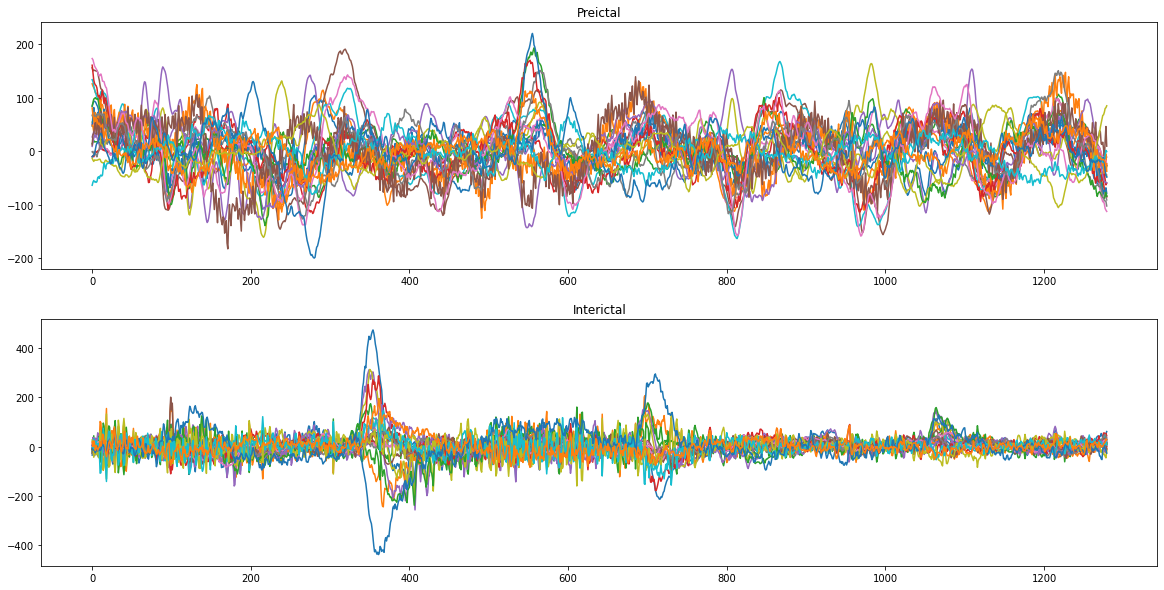

In [ ]:
# plot preictal vs interictal with subplots

fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(preictal[200])
axs[0].set_title("Preictal")
axs[1].plot(interictal[303])
axs[1].set_title("Interictal")



## Make dataset for baseline patient

In [ ]:
# x_train is a list of preictal samples
# y_train is a list of labels for the preictal samples
# x_train has shape (n, 1280, 22)
# y_train has shape (n, 1)
# n is the number of preictal samples
# if x_train[i] is a preictal sample, then y_train[i] is 1

X = np.concatenate((preictal, interictal), axis=0)
y = np.concatenate((np.ones((preictal.shape[0], 1)), np.zeros((interictal.shape[0], 1))), axis=0)

print("X:", X.shape)
print("y:", y.shape)
print("How many y=1:", np.sum(y))
print("How many y=0:", y.shape[0] - np.sum(y))

X: (840, 1280, 22)
y: (840, 1)
How many y=1: 420.0
How many y=0: 420.0


In [ ]:
# Shuffle the data
shuffle_indices = np.random.permutation(np.arange(X.shape[0]))
X = X[shuffle_indices]
y = y[shuffle_indices]

In [ ]:
# Split the data into train and test
train_size = int(X.shape[0] * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [ ]:
# Split test data into validation and test
val_size = int(X_test.shape[0] * 0.5)
X_val = X_test[:val_size]
y_val = y_test[:val_size]
X_test = X_test[val_size:]
y_test = y_test[val_size:]

In [ ]:
# Shapes
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (672, 1280, 22)
y_train: (672, 1)
X_val: (84, 1280, 22)
y_val: (84, 1)
X_test: (84, 1280, 22)
y_test: (84, 1)


## Make model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D

In [ ]:
X_train.shape[1], X_train.shape[2]

(1280, 22)

In [ ]:
# make model
model = Sequential()

model.add(Conv1D(256, 3, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(0.1))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1278, 256)         17152     
                                                                 
 activation (Activation)     (None, 1278, 256)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 639, 256)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 163584)            0         
                                                                 
 dense (Dense)               (None, 64)                10469440  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [ ]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# !sudo apt install graphviz

In [ ]:
# draw summary
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
21/21 [==============================] - 30s 35ms/step - loss: 406.7049 - accuracy: 0.7426 - val_loss: 13.5843 - val_accuracy: 0.9524
Epoch 2/10
21/21 [==============================] - 0s 16ms/step - loss: 19.9962 - accuracy: 0.9494 - val_loss: 14.6561 - val_accuracy: 0.9762
Epoch 3/10
21/21 [==============================] - 0s 16ms/step - loss: 1.7742 - accuracy: 0.9926 - val_loss: 15.4579 - val_accuracy: 0.9762
Epoch 4/10
21/21 [==============================] - 0s 15ms/step - loss: 0.8673 - accuracy: 0.9911 - val_loss: 20.3973 - val_accuracy: 0.9881
Epoch 5/10
21/21 [==============================] - 0s 15ms/step - loss: 3.2570 - accuracy: 0.9881 - val_loss: 17.4013 - val_accuracy: 0.9762
Epoch 6/10
21/21 [==============================] - 0s 15ms/step - loss: 0.2948 - accuracy: 0.9970 - val_loss: 14.7155 - val_accuracy: 0.9762
Epoch 7/10
21/21 [==============================] - 0s 15ms/step - loss: 0.3306 - accuracy: 0.9970 - val_loss: 20.3369 - val_accuracy: 0.9881
Ep

In [ ]:
# evaluate model
score = model.evaluate(X_test, y_test, batch_size=32)
print("Test loss:", score[0])

3/3 [==============================] - 0s 44ms/step - loss: 2.1753 - accuracy: 0.9881
Test loss: 2.1752572059631348


In [ ]:
# plot history
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)

c:\Users\crist\miniconda3\envs\gpu_base\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\crist\miniconda3\envs\gpu_base\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\crist\miniconda3\envs\gpu_base\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


NameError: name 'history' is not defined